In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import gget
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

os.chdir("..")
print(os.getcwd())

/home/yichaocai/work/indrop


### Inspect dropest outputs

In [4]:
sample = "test"
print(f"--- reading sample: {sample}")
cell_path = f"./output_v1_2/Estimated_counts/{sample}.est.cells.tsv"
gene_path = f"./output_v1_2/Estimated_counts/{sample}.est.genes.tsv"
mtx_path = f"./output_v1_2/Estimated_counts/{sample}.est.mtx"
rds_path = f"./output_v1_2/Estimated_counts/{sample}.est.rds"

df_cell = pd.read_table(cell_path, names=['cell'])
df_gene = pd.read_table(gene_path, names=['gene'])
print(f"cell num: {df_cell.shape[0]}; gene num: {df_gene.shape[0]}")

with open(mtx_path, 'r') as mtx:
    for i, l in enumerate(mtx):
        if(i==1):
            # print(l)
            mtx_row, mtx_col, mtx_nonZero = [int(_) for _ in l.strip().split(" ")]
            break
print(f"Matrix row, col, and nonZeroEntry: {mtx_row}, {mtx_col}, {mtx_nonZero}")

if(df_cell.shape[0] == mtx_col and df_gene.shape[0] == mtx_row):
    print("--- gene, cell, count matrix dimension check passed.")
    df_mtx = pd.read_table(mtx_path, sep=" ", skiprows=2, names=["row", "column", "count"])

--- reading sample: test
cell num: 251; gene num: 16770
Matrix row, col, and nonZeroEntry: 16770, 251, 116892
--- gene, cell, count matrix dimension check passed.


### Reconstruct gene-cell matrix

In [5]:
def reconstructMatrix(df_row, df_col, mtx_path):
    with open(mtx_path, 'r') as mtx:
        for i, l in enumerate(mtx):
            if(i == 0):
                continue
            elif(i == 1):
                # Initialize numpy array.
                mtx_row, mtx_col, mtx_nonZero = [int(_) for _ in l.strip().split(" ")]
                array = np.zeros((mtx_row, mtx_col), dtype=int)
            else:
                # In MatrixMarket format, the row and column are 1-based. Converting to 0-based.
                _mtx_row, _mtx_col, _mtx_nonZero = [int(_) for _ in l.strip().split(" ")]
                array[_mtx_row-1][_mtx_col-1] = _mtx_nonZero
    df = pd.DataFrame(array, columns = df_col.cell.tolist(), index=df_row.gene.tolist())
    return(df, array)


In [6]:
df, cnt_array = reconstructMatrix(df_gene, df_cell, mtx_path)
# print(np.max(cnt_array))

# Check max count index
print("--- Checking max count index")
max_idx = np.unravel_index(np.argmax(cnt_array, axis=None), cnt_array.shape)
max_gene = df_gene.iloc[max_idx[0],].tolist()[0]
max_cell = df_cell.iloc[max_idx[1],].tolist()[0]
print(max_gene, max_cell)

max_idx2 = np.unravel_index(df.values.argmax(), df.shape)
tmp = df.iloc[[max_idx2[0]], [max_idx2[1]]]
if(tmp.index.tolist()[0]==max_gene and tmp.columns.tolist()[0]==max_cell):
    print("Max count gene and cell index check passed.")


--- Checking max count index
ENST00000396895.3 TCATCCTTTTTATCAC
Max count gene and cell index check passed.


### Explore matrix

In [7]:
# Transform matrix in to long format
df_long = df.reset_index(drop=False).melt(id_vars=['index']).rename(columns={'index':'gene', 'variable':'cell', 'value': 'count'})
df_long.sort_values(['count'], ascending=False)

,gene,cell,count
3941182,ENST00000396895.3,TCATCCTTTTTATCAC,48
3957747,ENST00000362079.2,GAGACGATGGCTGGTGCA,47
4058367,ENST00000362079.2,GACACGGACTCGGGTAGT,44
3286947,ENST00000362079.2,GATAACCATCGTCCAAAG,42
1677027,ENST00000362079.2,GATTGGCGTTTTAAGCGT,39
...,...,...,...
1480607,ENST00000708561.1,GACGCCTTGAAAGTAATC,0
1480608,ENST00000456172.5,GACGCCTTGAAAGTAATC,0
97350,ENST00000480224.1,TGAAACACACGCATACATT,0
1480610,ENST00000704582.1,GACGCCTTGAAAGTAATC,0


#### Aggregate per gene

/home/yichaocai/miniforge3/envs/py3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yichaocai/miniforge3/envs/py3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Number of genes')

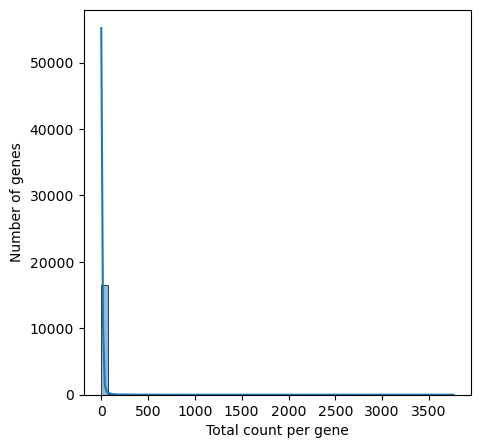

In [8]:
# Gene with total count across all cell
plot_df = (df_long
 .groupby(['gene'])
 .agg(total_count=('count', 'sum'), max_count=('count', 'max'), min_count=('count', 'min'))
 .sort_values(['total_count'], ascending=False)
 .reset_index()
)

# Long tail of gene quantification.
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=plot_df, x="total_count", kde=True, bins=50, ax = ax)
ax.set_xlabel("Total count per gene")
ax.set_ylabel("Number of genes")
# ax.set_yticks(range(int(ax.get_yticks().max())))


In [9]:
def geneInfo(df, total_count=500, max_count=10, min_count=0):
    '''Input: gene cell matrix in long form.'''
    df2 = (df
            .groupby(['gene'])
            .agg(total_count=('count', 'sum'), max_count=('count', 'max'), min_count=('count', 'min'))
            .sort_values(['total_count'], ascending=False)
            .reset_index()
            )
    query = f'total_count >= {total_count} & max_count >= {max_count} & min_count >= {min_count}'
    print(f'--- Threshold in filtering genes for GO analysis: {query}')
    selected_genes = (df2
                      .query(query) 
                      )
    print(f'--- Number of gene after filtering: {selected_genes.shape[0]}')
    selected_genes_info = gget.info(selected_genes.gene.values.tolist())

    non_MT_genes_info = (selected_genes_info
                    .query('~ seq_region_name.str.contains("_")') # Filter out genes mapped to scaffold chromosomes
                    .query('~ (seq_region_name == "MT")') # Filter out MT genes
                    ) 
    print(f'--- Non MT genes: {non_MT_genes_info.shape[0]}')

    return(selected_genes, non_MT_genes_info)


def geneEnrich(df, database="ontology"):
    '''Input: Dataframe from gget.info().'''
    enrich_res = gget.enrichr(df.parent_gene.tolist(), ensembl=True, database=database, plot=True)

    return(enrich_res)


def queryNEnrich(df, total_count=500, max_count=10, min_count=0, database="ontology", non_MT_genes_info=None):
    selected_genes = None
    if non_MT_genes_info is None:
        selected_genes, non_MT_genes_info = geneInfo(df, total_count=500, max_count=10, min_count=0)
    enrich_res = gget.enrichr(non_MT_genes_info.parent_gene.tolist(), ensembl=True, database=database, plot=True)
    return(selected_genes, non_MT_genes_info, enrich_res)


Wed Sep 13 09:59:29 2023 INFO We noticed that you may have passed a version number with your Ensembl ID.
Please note that gget info will always return information linked to the latest Ensembl ID version (see 'ensembl_id').


--- Threshold in filtering genes for GO analysis: total_count >= 500 & max_count >= 10 & min_count >= 0
--- Number of gene after filtering: 27


Wed Sep 13 10:00:02 2023 WARNING No UniProt entry was found for ID ENST00000679031.
Wed Sep 13 10:00:14 2023 WARNING No UniProt entry was found for ID ENST00000709241.
Wed Sep 13 10:00:25 2023 WARNING No UniProt entry was found for ID ENST00000474582.
Wed Sep 13 10:00:29 2023 WARNING No reviewed UniProt results were found for ID ENST00000697754. Returning all unreviewed results.
Wed Sep 13 10:00:58 2023 WARNING No UniProt entry was found for ID ENST00000568952.
Wed Sep 13 10:01:15 2023 WARNING No reviewed UniProt results were found for ID ENST00000406022. Returning all unreviewed results.
Wed Sep 13 10:01:24 2023 WARNING No reviewed UniProt results were found for ID ENST00000624069. Returning all unreviewed results.
Wed Sep 13 10:01:34 2023 WARNING No UniProt entry was found for ID ENST00000633925.
Wed Sep 13 10:01:44 2023 WARNING No reviewed UniProt results were found for ID ENST00000644684. Returning all unreviewed results.
Wed Sep 13 10:01:47 2023 WARNING No reviewed UniProt results

--- Non MT genes: 19


Wed Sep 13 10:04:07 2023 INFO Performing Enichr analysis on the following gene symbols: HBG2, EEF1A1, RPL23, H4C3, RPS8, RPSA, RPS11, RPS5, RPS12, FTH1, nan, RPS15, RPL10, HBE1, RPL13A, H1-2, RPL15, RPL10, RPS15A


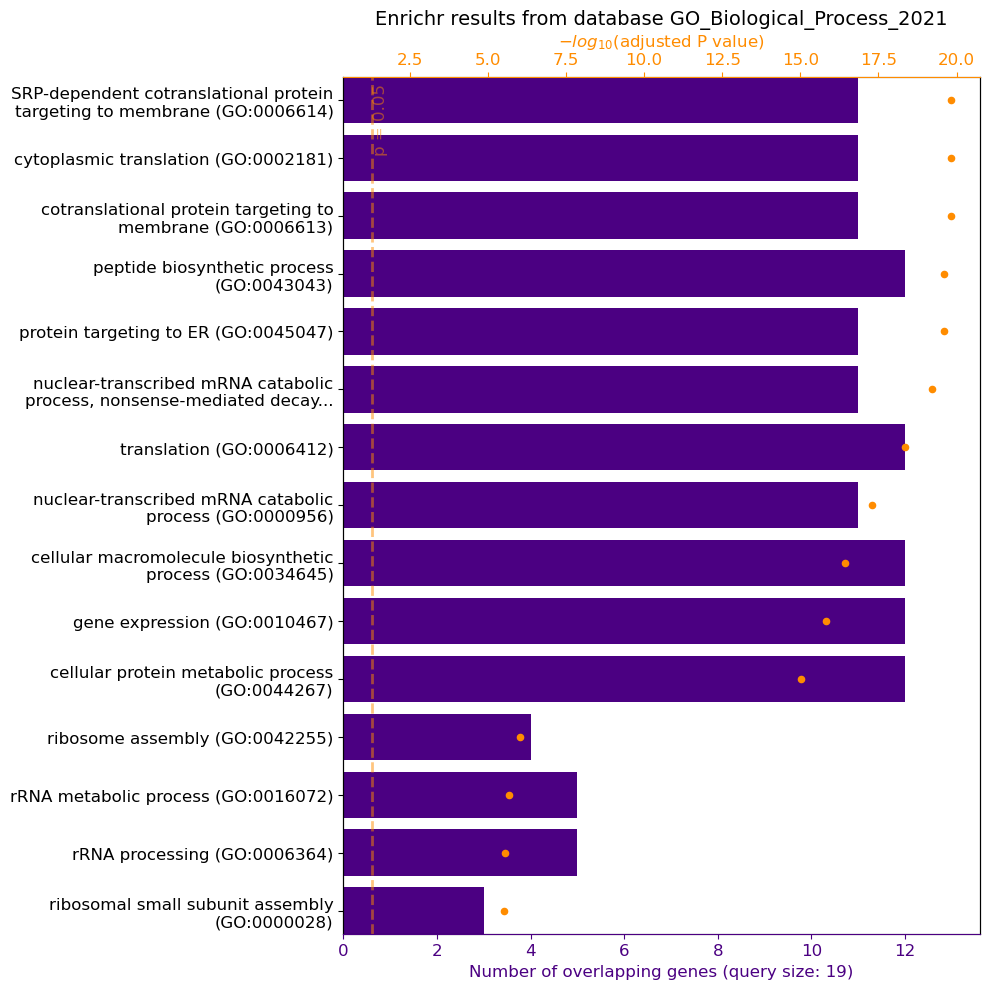

In [10]:
# Majority GO terms are translation, transcription related processed. No K562 related terms found at highly expressed genes.
selected_genes, genes_GO, enrich_res_GO = queryNEnrich(df_long, 500, 10, 0, 'ontology')

Wed Sep 13 10:04:10 2023 INFO Performing Enichr analysis using database KEGG_2021_Human. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Wed Sep 13 10:04:10 2023 INFO Getting gene symbols from Ensembl IDs.
Wed Sep 13 10:06:23 2023 INFO Performing Enichr analysis on the following gene symbols: HBG2, EEF1A1, RPL23, H4C3, RPS8, RPSA, RPS11, RPS5, RPS12, FTH1, nan, RPS15, RPL10, HBE1, RPL13A, H1-2, RPL15, RPL10, RPS15A


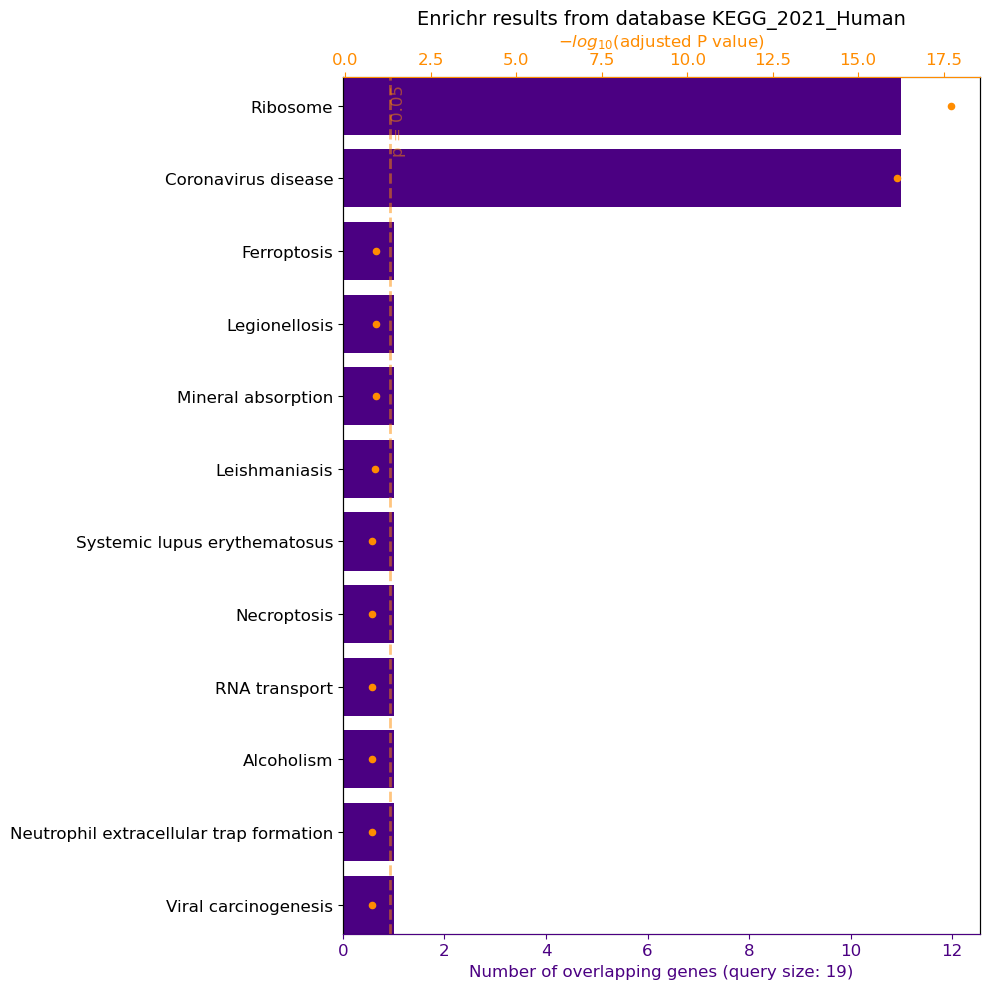

In [11]:
# database='pathway' (KEGG) failed because of connection error (ConnectionResetError(104, 'Connection reset by peer'))
# Ribosome pathway is as expected, but coronavirus disease pathway also pops up.
_, genes_KEGG, enrich_res_KEGG = queryNEnrich(df_long, 500, 10, 0, 'pathway', non_MT_genes_info=genes_GO)

Wed Sep 13 10:12:26 2023 INFO Performing Enichr analysis using database Reactome_2022.
Wed Sep 13 10:12:26 2023 INFO Getting gene symbols from Ensembl IDs.
Wed Sep 13 10:14:36 2023 INFO Performing Enichr analysis on the following gene symbols: HBG2, EEF1A1, RPL23, H4C3, RPS8, RPSA, RPS11, RPS5, RPS12, FTH1, nan, RPS15, RPL10, HBE1, RPL13A, H1-2, RPL15, RPL10, RPS15A


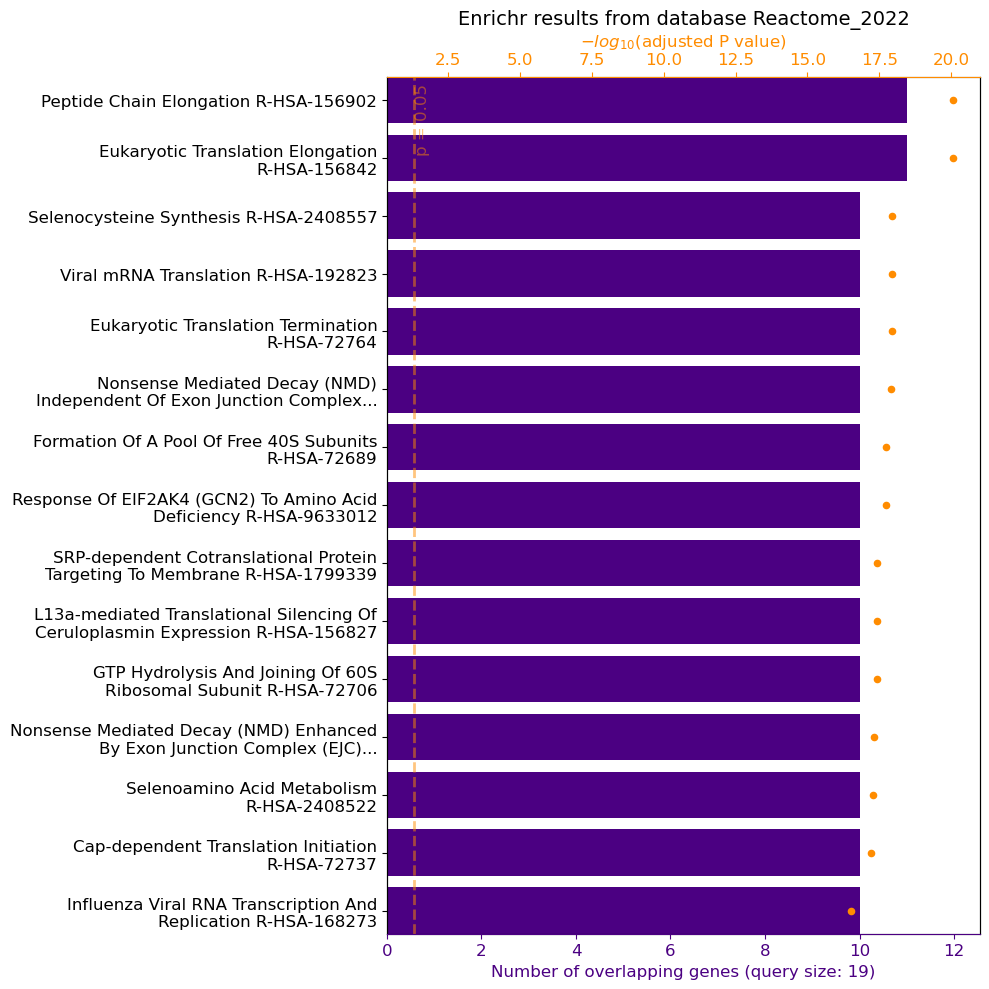

In [25]:
# Translation pathway highlighted. And also influenza pathway also shows up (mostly ribosome genes).
_, genes_REACTOME, enrich_res_REACTOME = queryNEnrich(df_long, 500, 10, 0, 'Reactome_2022', non_MT_genes_info=genes_GO)

In [30]:
enrich_res_REACTOME.iloc[[14], :].overlapping_genes.values

array([list(['RPS15', 'RPS15A', 'RPS8', 'RPL23', 'RPS5', 'RPL13A', 'RPSA', 'RPL15', 'RPS11', 'RPS12'])],
      dtype=object)

In [33]:
enrich_res_KEGG.iloc[[1], :].overlapping_genes.values

array([list(['RPS15', 'RPS15A', 'RPL10', 'RPS8', 'RPL23', 'RPS5', 'RPL13A', 'RPSA', 'RPL15', 'RPS11', 'RPS12'])],
      dtype=object)

#### Aggregate per cell

/home/yichaocai/miniforge3/envs/py3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yichaocai/miniforge3/envs/py3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


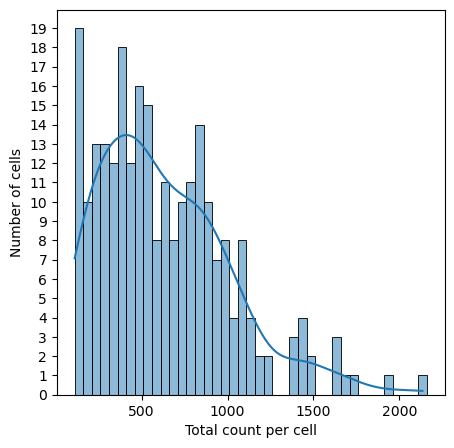

In [13]:
# Cells with most total count across all genes
plot_df = (df_long
 .groupby(['cell'])
 .agg(total_count=('count', 'sum'), max_count=('count', 'max'), min_count=('count', 'min'))
 .sort_values(['total_count'], ascending=False)
 .reset_index()
)

# The majority of the cells have <1000 transcripts.
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=plot_df, x="total_count", kde=True, binwidth=50, ax = ax)
ax.set_xlabel("Total count per cell")
ax.set_ylabel("Number of cells")
ax.set_yticks(range(int(ax.get_yticks().max())))

#### PCA on a selected list of gene and cell

In [14]:
# Only look at cell with total_count >= 500 and max_count of transcript >= 10
cell_filteredLow = plot_df.query('total_count >= 500 & max_count >= 10').cell.tolist()
n_cell = len(cell_filteredLow)
# Only look at transcript with average_count >= 0.5 (at least 70.5 count in all 141 cells from the previous step)
gene_filteredLow = (df_long
 .query('cell.isin(@cell_filteredLow)')
 .groupby(['gene'])
 .agg(total_count=('count', 'sum'), max_count=('count', 'max'), min_count=('count', 'min'))
 .sort_values(['total_count', 'max_count', 'min_count'])
 .assign(avg_count=lambda x: x.total_count / n_cell)
 .query('avg_count >= 0.5')
 .index.tolist()
)
n_gene = len(gene_filteredLow)

print(f"--- Total gene and cell considered in PCA: {n_gene}, {n_cell}")

df_long_reduced = (df_long
                   .query('cell.isin(@cell_filteredLow)')
                   .query('gene.isin(@gene_filteredLow)')
                   .pivot(index='cell', columns='gene', values='count')
                   )

df_long_reduced

--- Total gene and cell considered in PCA: 231, 141


gene,ENST00000009589.8,ENST00000196551.8,ENST00000202773.14,ENST00000215565.3,ENST00000215754.8,ENST00000216281.13,ENST00000221975.6,ENST00000230050.4,ENST00000233893.10,ENST00000234590.10,...,ENST00000682106.1,ENST00000685106.1,ENST00000691158.1,ENST00000696046.1,ENST00000697754.1,ENST00000707484.1,ENST00000707881.1,ENST00000708077.1,ENST00000709241.1,ENST00000709894.1
cell,,,,,,,,,,,,,,,,,,,,,
AAAACGCCTCACAAGGC,1,6,3,2,1,0,3,3,0,0,...,0,1,1,0,2,1,1,1,2,1
AAAACTCGAATGACCGA,3,3,2,0,0,3,4,5,2,2,...,0,0,0,0,4,1,3,1,2,3
AACCCATATCGTAGAAG,0,2,0,0,0,0,1,1,0,1,...,1,0,0,1,5,1,0,0,3,0
AACGAAACGGAAGTGCC,1,7,2,0,4,3,5,9,1,3,...,1,1,0,1,6,0,0,2,6,1
AACGCAGAGTTGGACTT,6,6,4,0,2,4,7,4,2,1,...,0,0,1,0,4,1,1,2,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGATGATAACATCACCGAG,4,5,6,2,1,5,3,10,1,1,...,0,2,2,2,8,0,1,2,12,3
TGATGTCTTTCAGAGACTA,1,7,6,1,2,1,5,6,1,1,...,0,1,0,0,7,0,2,1,6,2
TGCCTCACGCGCATTC,0,3,3,0,0,2,2,1,0,1,...,0,0,0,0,1,0,0,1,5,3


In [15]:
# PCA on the reduced gene-cell matrix.
x = df_long_reduced.values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = [f'principal_component_{i}' for i in range(1, 11)])
principalDf

,principal_component_1,principal_component_2,principal_component_3,principal_component_4,principal_component_5,principal_component_6,principal_component_7,principal_component_8,principal_component_9,principal_component_10
0,-2.187545,-0.690660,-0.137320,-0.855239,-3.154909,0.405727,-1.440608,1.881839,2.228451,1.398253
1,-0.339934,2.662997,-0.075804,0.055055,0.530352,1.128895,-1.360606,3.675056,-1.338292,1.153295
2,-6.612381,-0.431553,-0.116964,-1.666635,-1.336595,0.217431,1.216144,-0.613880,0.124717,-0.842167
3,8.727598,-0.579149,-1.911958,4.273181,5.034132,-4.812161,-0.977256,-4.949599,0.591092,2.533078
4,4.382399,-3.328078,-0.315068,1.148740,-1.029594,-3.638828,-1.473887,-1.048535,2.860614,-1.873442
...,...,...,...,...,...,...,...,...,...,...
136,14.789871,8.751001,-8.184302,-2.488694,7.635757,-2.388038,-6.150984,2.027387,-5.348490,-6.277523
137,0.510549,-0.897130,0.505294,2.374162,1.157435,-0.359677,-1.381565,-1.767563,4.203049,2.916273
138,-5.476089,-1.307342,-1.006224,0.519581,-0.171963,-2.069333,0.247043,-1.014916,0.321041,-1.790400
139,-3.672797,-0.762258,2.856723,0.400099,-1.446552,2.555340,0.547826,0.964654,-2.580877,1.156253


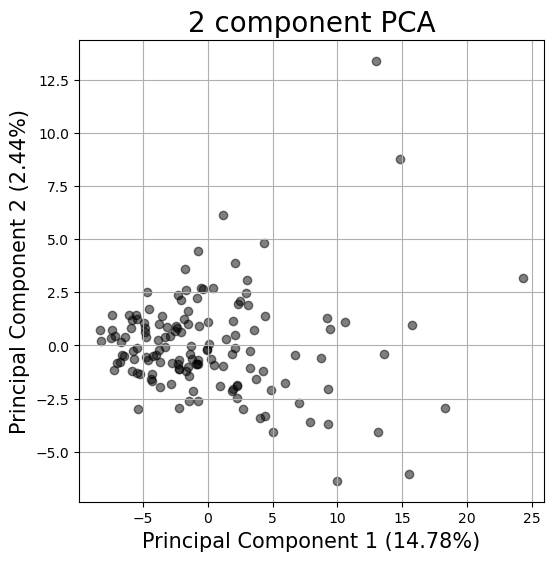

In [16]:
# Plot PC1, PC2
# The cells are from human K562 cells (239 cells).
explained_PC_1 = pca.explained_variance_ratio_[0]
explained_PC_2 = pca.explained_variance_ratio_[1]

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(principalDf.principal_component_1,
           principalDf.principal_component_2,
           c='black', alpha=0.5)
ax.set_xlabel(f'Principal Component 1 ({explained_PC_1:.2%})', fontsize = 15)
ax.set_ylabel(f'Principal Component 2 ({explained_PC_2:.2%})', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.grid()

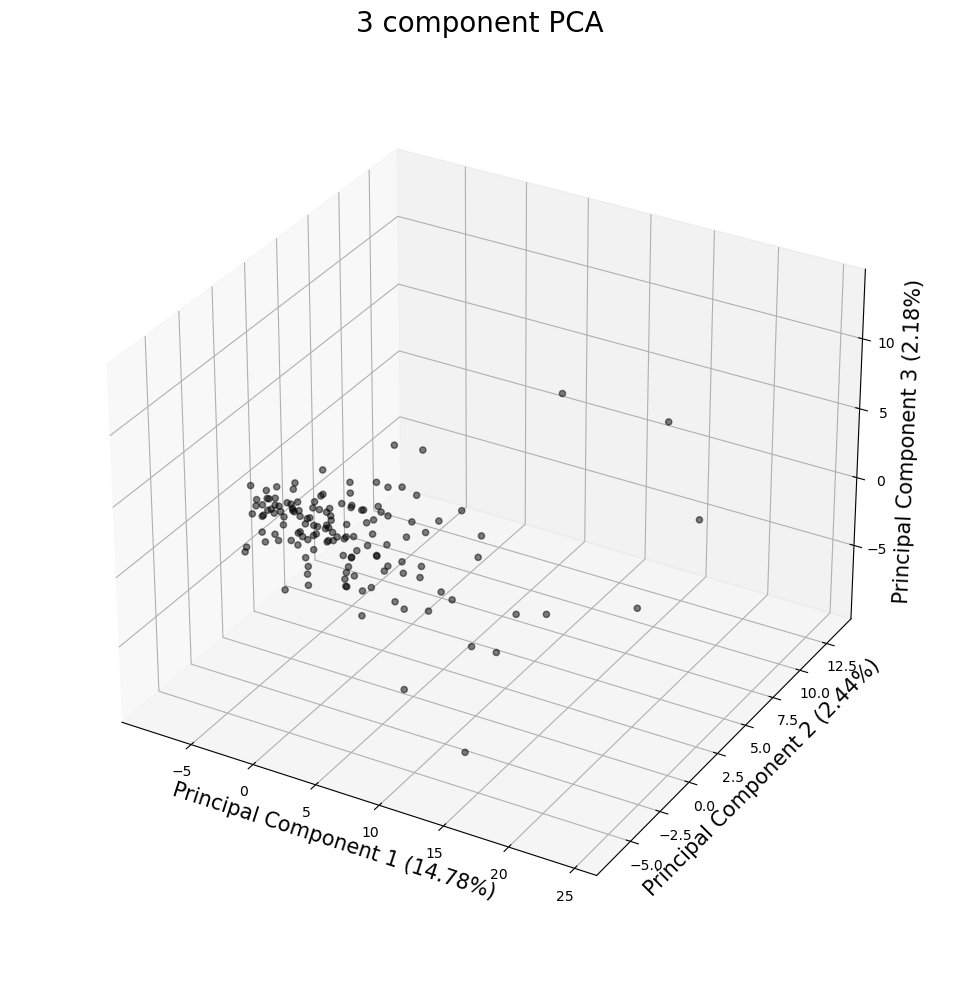

In [17]:
# Plot PC1, PC2, PC3
explained_PC_1 = pca.explained_variance_ratio_[0]
explained_PC_2 = pca.explained_variance_ratio_[1]
explained_PC_3 = pca.explained_variance_ratio_[2]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_box_aspect(aspect=None, zoom=0.9)

ax.scatter(xs=principalDf.principal_component_1,
           ys=principalDf.principal_component_2,
           zs=principalDf.principal_component_3,
           c='black', alpha=0.5)
ax.set_xlabel(f'Principal Component 1 ({explained_PC_1:.2%})', fontsize = 15)
ax.set_ylabel(f'Principal Component 2 ({explained_PC_2:.2%})', fontsize = 15)
ax.set_zlabel(f'Principal Component 3 ({explained_PC_3:.2%})', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
# ax.grid()
plt.tight_layout()

#### T-SNE

##### T-SNE vanila

In [18]:
x = df_long_reduced.values
x = StandardScaler().fit_transform(x)

tsne = TSNE(n_components=3, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(x)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 141 samples in 0.001s...
[t-SNE] Computed neighbors for 141 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 141 / 141
[t-SNE] Mean sigma: 3.222655


[t-SNE] KL divergence after 250 iterations with early exaggeration: 139.378387
[t-SNE] KL divergence after 300 iterations: 4.567554


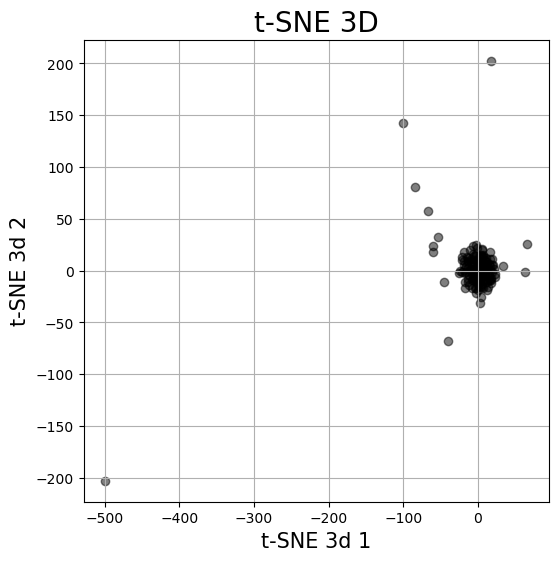

In [19]:
# Plot TSNE 1, TSNE 2
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(tsne_results[:,0],
           tsne_results[:,1],
           c='black', alpha=0.5)
ax.set_xlabel(f't-SNE 3d 1', fontsize = 15)
ax.set_ylabel(f't-SNE 3d 2', fontsize = 15)
ax.set_title('t-SNE 3D', fontsize = 20)
ax.grid()

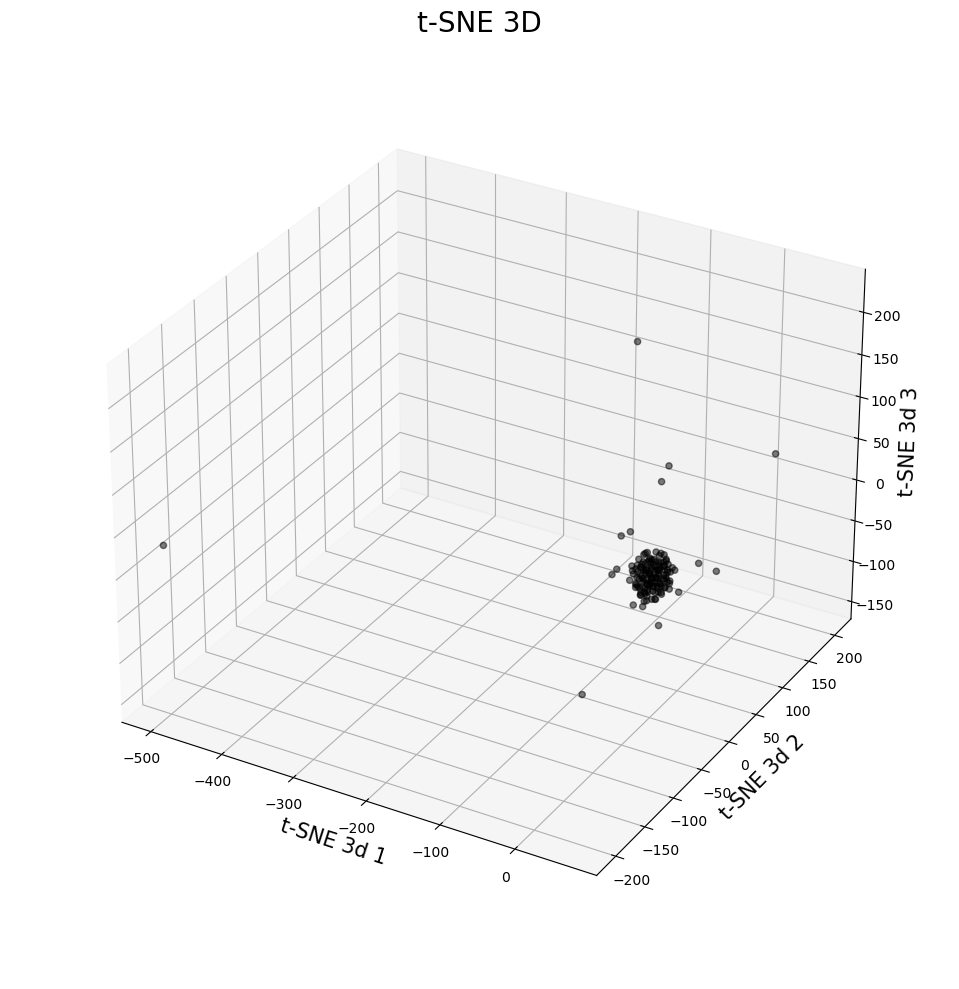

In [20]:
# Plot TSNE 1, TSNE 2, TSNE 3
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_box_aspect(aspect=None, zoom=0.9)

ax.scatter(xs=tsne_results[:,0],
           ys=tsne_results[:,1],
           zs=tsne_results[:,2],
           c='black', alpha=0.5)
ax.set_xlabel(f't-SNE 3d 1', fontsize = 15)
ax.set_ylabel(f't-SNE 3d 2', fontsize = 15)
ax.set_zlabel(f't-SNE 3d 3', fontsize = 15)
ax.set_title('t-SNE 3D', fontsize = 20)
# ax.grid()
plt.tight_layout()

##### T-SNE after PCA

In [21]:
x = df_long_reduced.values
x = StandardScaler().fit_transform(x)

# Use 60 PCs, explained >80% of variance
num_PC = 60
pca = PCA(n_components=num_PC)
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = [f'principal_component_{i}' for i in range(1, num_PC+1)])
principalDf



print(f"--- Total variance explained by {num_PC} PCs: {np.sum(pca.explained_variance_ratio_)}")


tsne = TSNE(n_components=3, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(principalComponents)


--- Total variance explained by 60 PCs: 0.8122506588135396
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 141 samples in 0.012s...
[t-SNE] Computed neighbors for 141 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 141 / 141
[t-SNE] Mean sigma: 3.286403
[t-SNE] KL divergence after 250 iterations with early exaggeration: 135.792542
[t-SNE] KL divergence after 300 iterations: 4.582000


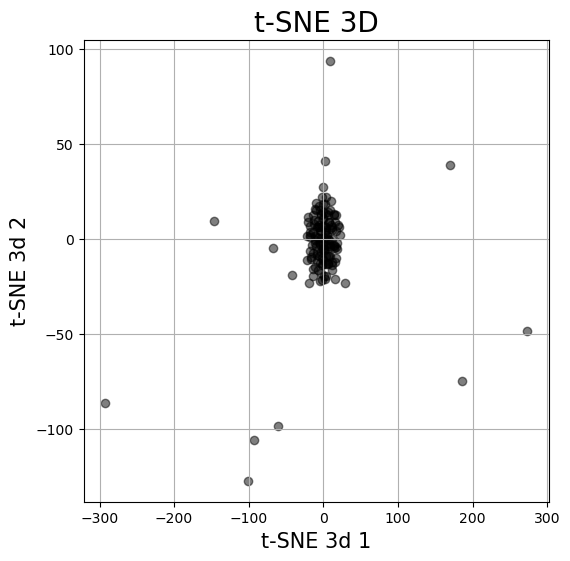

In [22]:
# Plot TSNE 1, TSNE 2
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(tsne_results[:,0],
           tsne_results[:,1],
           c='black', alpha=0.5)
ax.set_xlabel(f't-SNE 3d 1', fontsize = 15)
ax.set_ylabel(f't-SNE 3d 2', fontsize = 15)
ax.set_title('t-SNE 3D', fontsize = 20)
ax.grid()

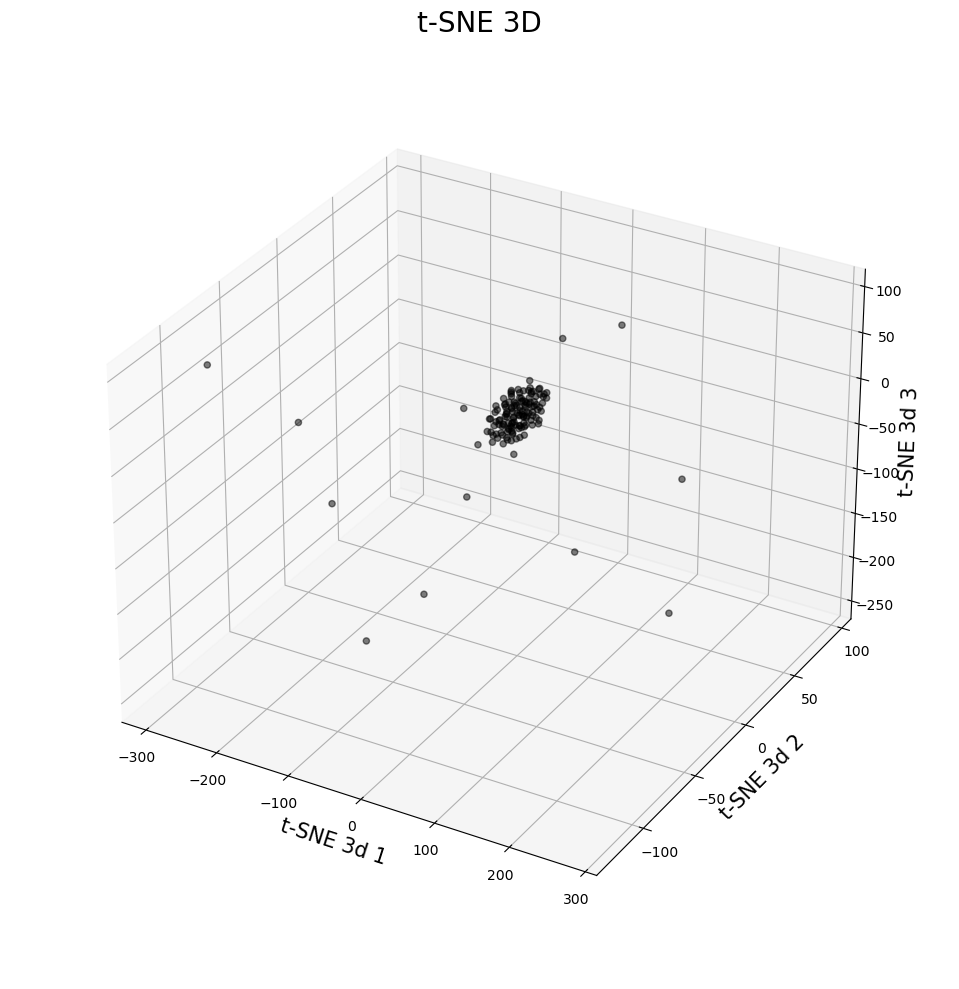

In [23]:
# Plot TSNE 1, TSNE 2, TSNE 3
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_box_aspect(aspect=None, zoom=0.9)

ax.scatter(xs=tsne_results[:,0],
           ys=tsne_results[:,1],
           zs=tsne_results[:,2],
           c='black', alpha=0.5)
ax.set_xlabel(f't-SNE 3d 1', fontsize = 15)
ax.set_ylabel(f't-SNE 3d 2', fontsize = 15)
ax.set_zlabel(f't-SNE 3d 3', fontsize = 15)
ax.set_title('t-SNE 3D', fontsize = 20)
# ax.grid()
plt.tight_layout()

#### UMAP

In [41]:
import umap

x = df_long_reduced.values
x = StandardScaler().fit_transform(x)

embedding = umap.UMAP().fit_transform(x)

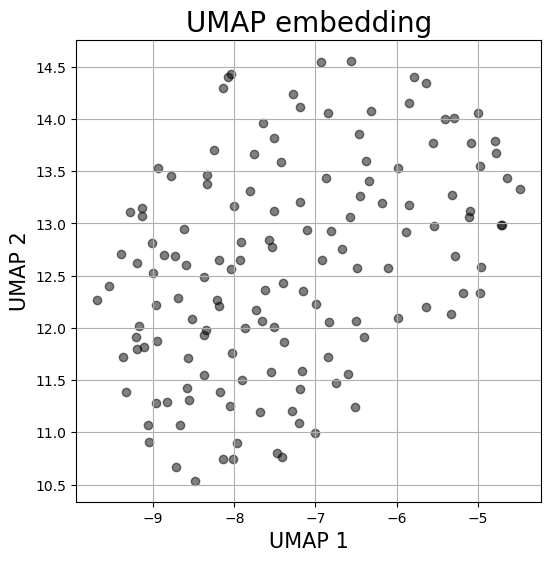

In [42]:
# Plot TSNE 1, TSNE 2
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(embedding[:,0],
           embedding[:,1],
           c='black', alpha=0.5)
ax.set_xlabel(f'UMAP 1', fontsize = 15)
ax.set_ylabel(f'UMAP 2', fontsize = 15)
ax.set_title('UMAP embedding', fontsize = 20)
ax.grid()

### scanpy

In [160]:
import scanpy as sc
import anndata as ad

In [161]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.5 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.11.2 pandas==2.1.0 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10


In [162]:
# Construct a AnnoData object
X = df.values.T
obs = df.columns.to_frame().rename(columns={0:'cell'}).reset_index(drop=True)

# Combine transcript information from UCSC associated with the transcript.
# Read in transcript metadata.
gene_anno = pd.read_table("./anno/UCSC_wgEncodeCompV22.tsv.gz")
colNames = gene_anno.columns.tolist()
newColNames = [i.split(".")[-1] for i in colNames]
newColNames[0] = "transcriptId"
newColNames[6] = "geneName"
gene_anno = (gene_anno
.rename(columns=dict(zip(colNames, newColNames)))
.assign(transcriptId_stable=lambda x: x.transcriptId.str.split('.', expand=True)[0])
)

# Combine transcript information to transcript id.
# Some of the transcript does not have associated gene name. Even using gencode metadata of the same version, filling them with transcript ID.
var = (pd.DataFrame(index=df.index)
.reset_index(names="transcriptId")
.assign(transcriptId_stable=lambda x: x.transcriptId.str.split('.', expand=True)[0])
.merge(gene_anno, how='left', on=['transcriptId_stable'])
.drop(columns=["transcriptId_y"])
.rename(columns={"transcriptId_x": "transcriptId"})
.assign(geneName=lambda x: np.where(x.geneName.isna(), x.transcriptId, x.geneName))
.set_index('transcriptId')
)

adata = ad.AnnData(X, obs=obs, var=var, dtype='int32')
adata.write(f'./output_v1_2/Estimated_counts/{sample}.h5ad')
adata

... storing 'chrom' as categorical
... storing 'strand' as categorical
... storing 'geneName' as categorical
... storing 'geneId' as categorical


AnnData object with n_obs × n_vars = 251 × 16770
    obs: 'cell'
    var: 'transcriptId_stable', 'chrom', 'strand', 'txStart', 'txEnd', 'exonCount', 'geneName', 'geneId'

normalizing counts per cell
    finished (0:00:00)


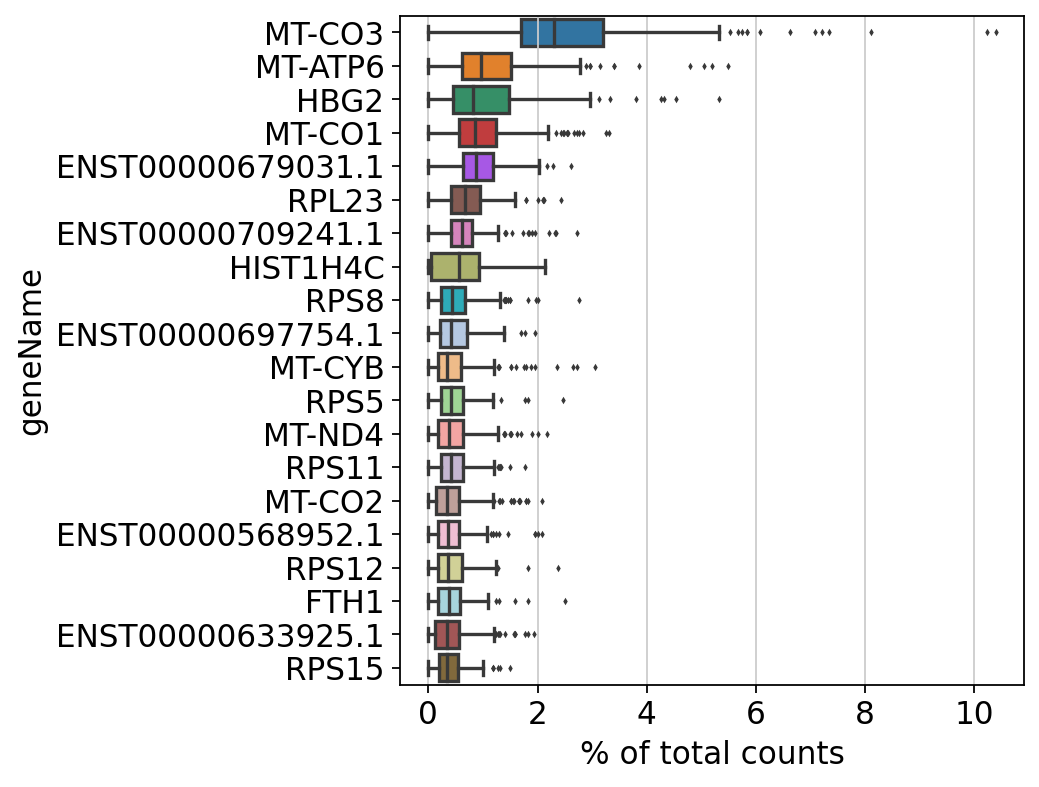

In [163]:
%%capture --no-display
# Turn off future wawrning for is_categorical error when calling seaborn.
sc.pl.highest_expr_genes(adata, n_top=20, gene_symbols='geneName')

In [164]:
# Basic filtering 
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 32 cells that have less than 200 genes expressed
filtered out 8856 genes that are detected in less than 3 cells


/home/yichaocai/miniforge3/envs/py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/yichaocai/miniforge3/envs/py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


AnnData object with n_obs × n_vars = 219 × 7914
    obs: 'cell', 'n_genes'
    var: 'transcriptId_stable', 'chrom', 'strand', 'txStart', 'txEnd', 'exonCount', 'geneName', 'geneId', 'n_cells'

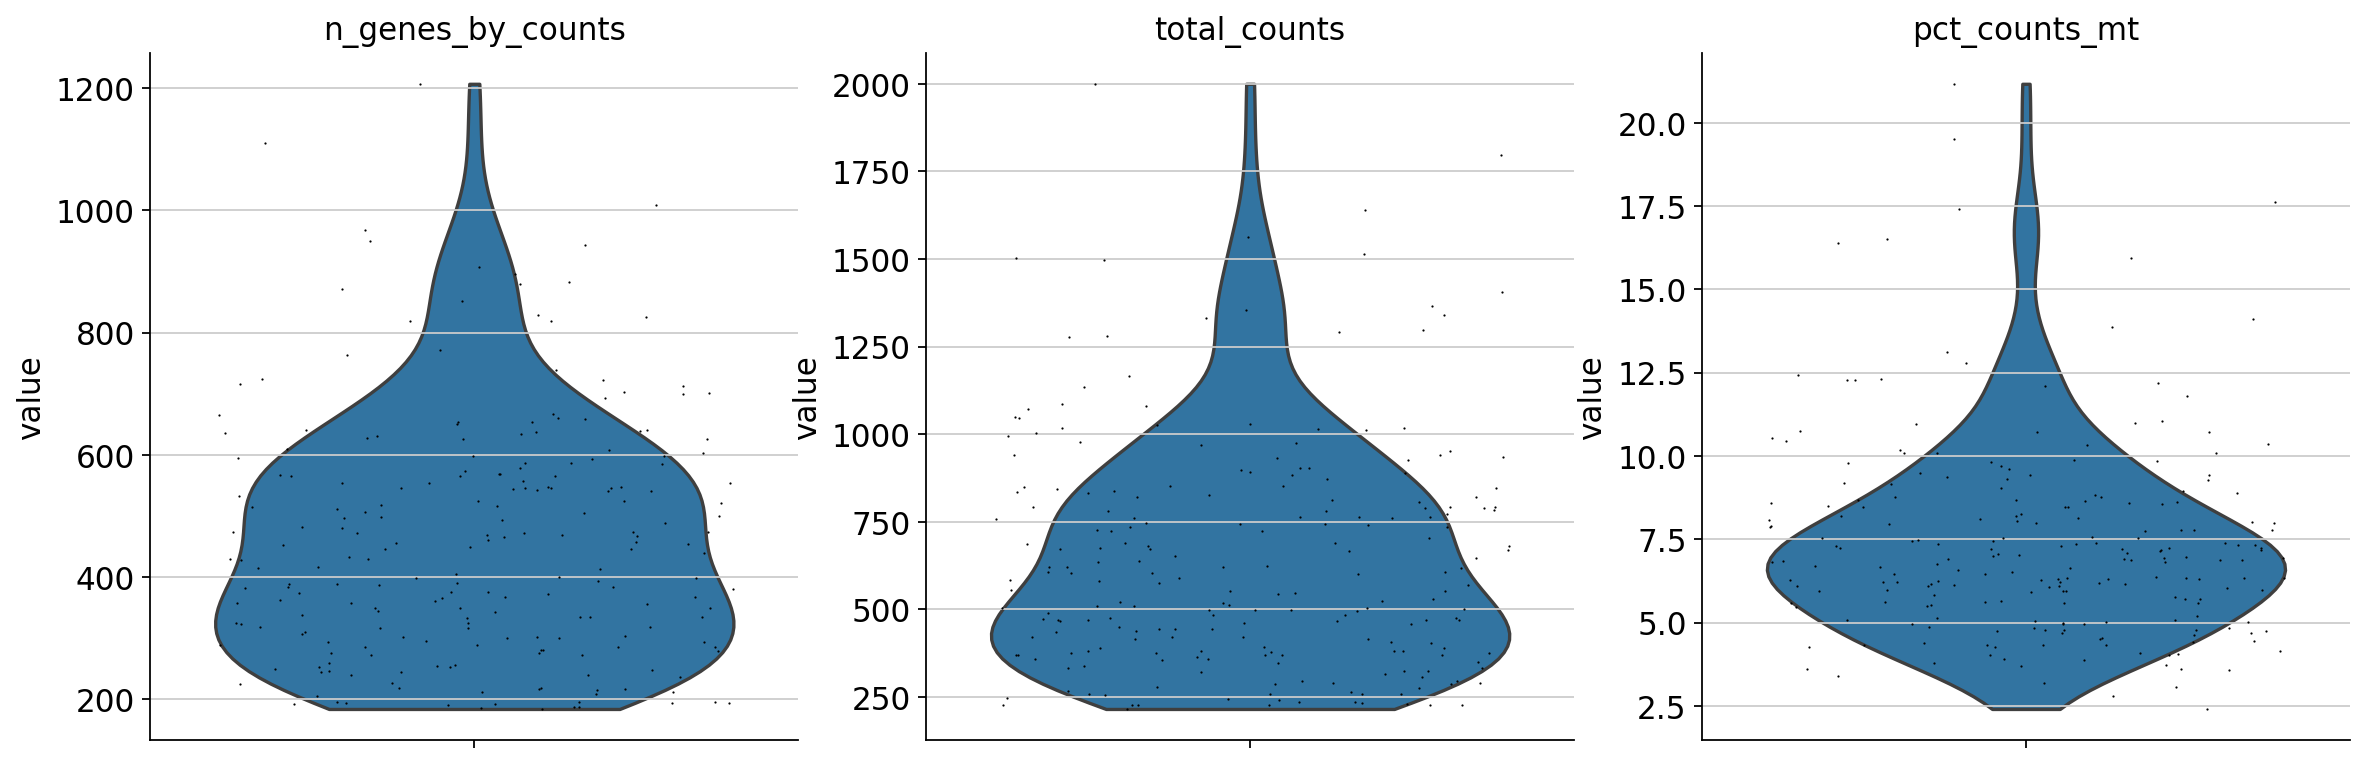

In [165]:
%%capture --no-display
# QC on mitochondrial genes
adata.var['mt'] = adata.var.geneName.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

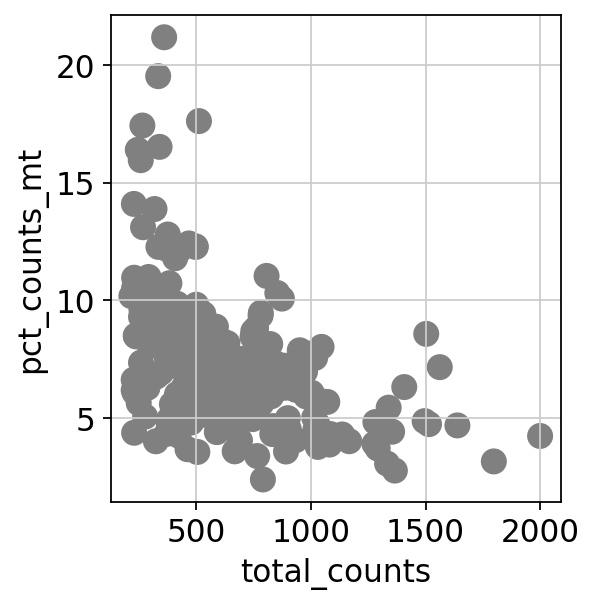

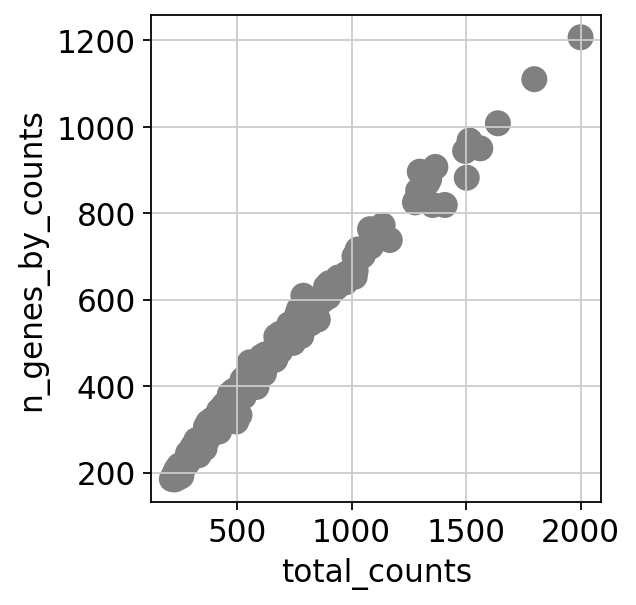

In [166]:
# Cell with small total_counts have high percentage of MT genes
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
# Number of genes in a cell positively correlate with the total_counts
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [167]:
# Filtering out cells with to many transcripts
# Filtering out cells with high MT percentage
adata = adata[adata.obs.n_genes_by_counts < 1000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata

/home/yichaocai/miniforge3/envs/py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


View of AnnData object with n_obs × n_vars = 41 × 7914
    obs: 'cell', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'transcriptId_stable', 'chrom', 'strand', 'txStart', 'txEnd', 'exonCount', 'geneName', 'geneId', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/yichaocai/miniforge3/envs/py3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


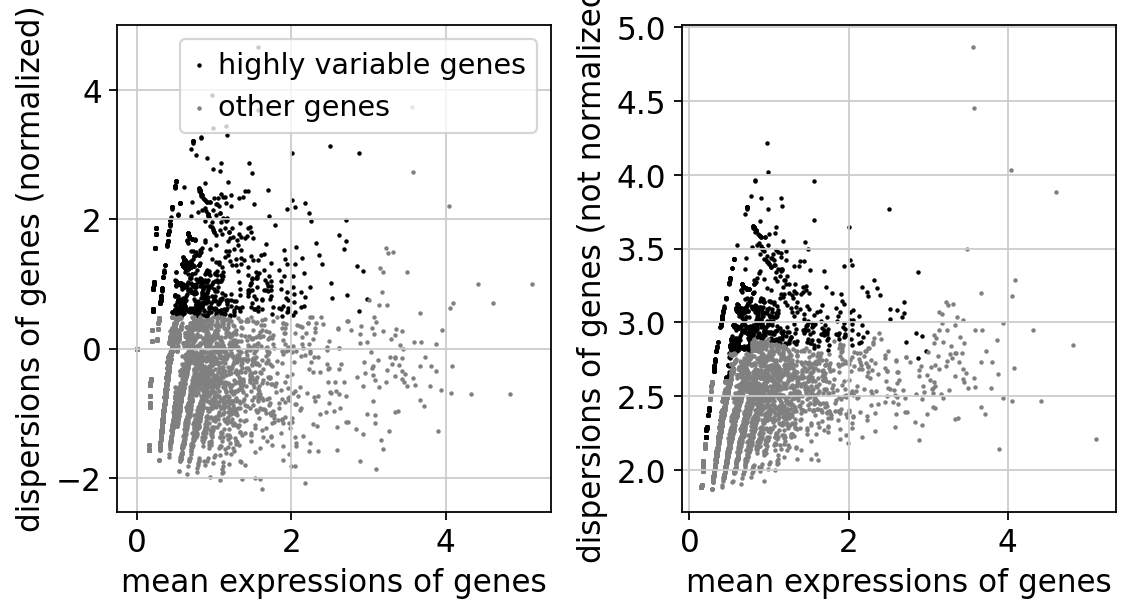

In [168]:
# Normalize count and plot highly variable genes
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [169]:
# Freeze the normalized and scaled count matrix in .raw attribute for later use.
adata.raw = adata
# Filter only highly variable genes. (Unnecessary as PCA in scanpy would do it automatically)
adata = adata[:, adata.var.highly_variable]
# Regress out count per cell and percentage of MT genes. Clip genes with > 10 standard deviation
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']


/home/yichaocai/miniforge3/envs/py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/yichaocai/miniforge3/envs/py3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:619: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if keys[0] in adata.obs_keys() and is_categorical_dtype(adata.obs[keys[0]]):


    finished (0:00:05)


computing PCA
    on highly variable genes
    with n_comps=40
    finished (0:00:00)


/home/yichaocai/miniforge3/envs/py3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


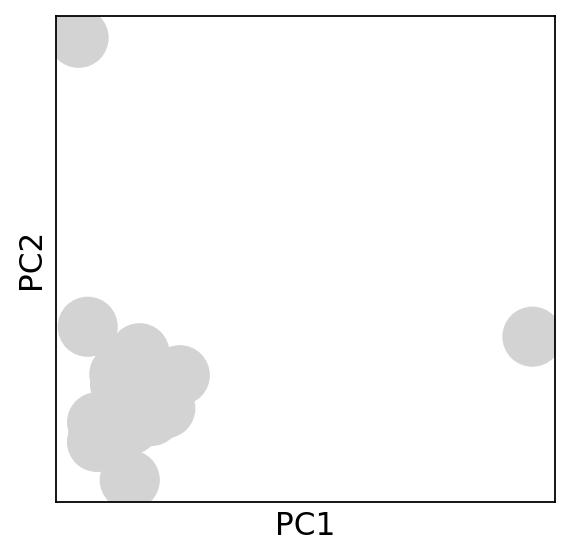

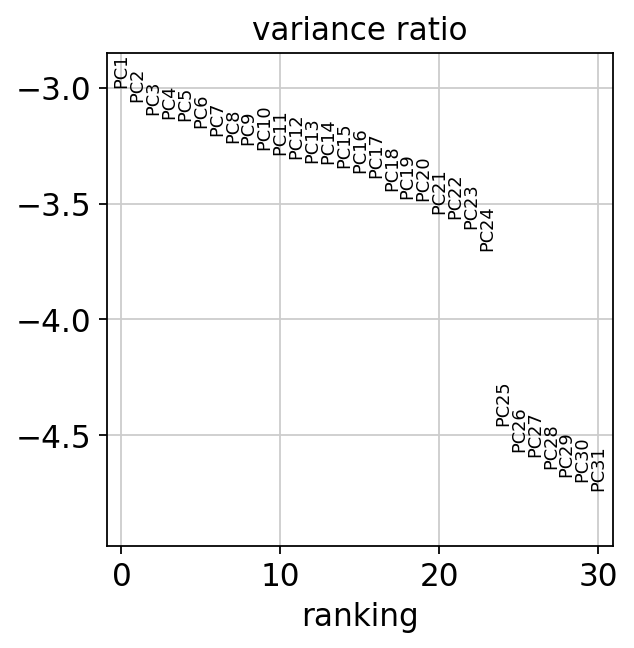

In [172]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)
# First 24 PCs explain the majority of the variance.
sc.pl.pca_variance_ratio(adata, log=True)

In [173]:
# Compute the neighborhood graph of cells
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


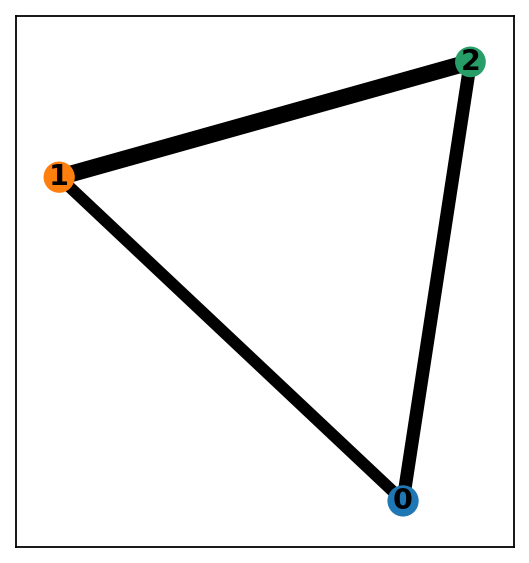

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


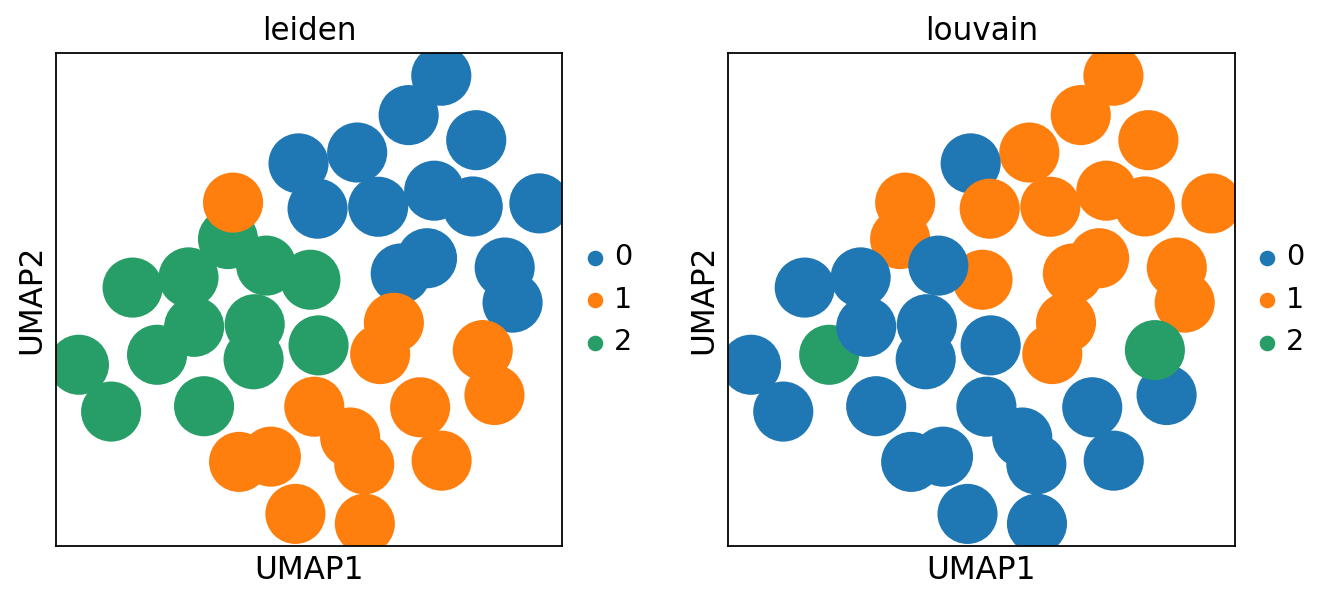

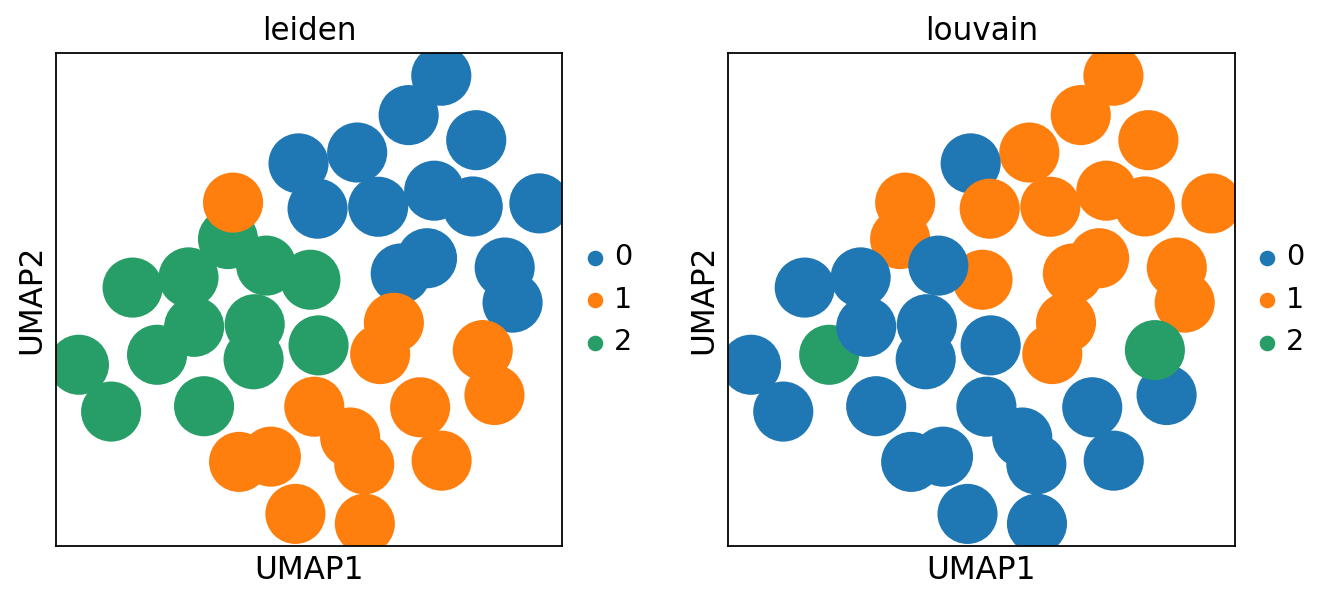

In [186]:
%%capture --no-display

# Run Leiden to identify clusters
sc.tl.leiden(adata)
# Run louvain to identify subgroups
sc.tl.louvain(adata)
# Map out a partition-based graph abstraction (PAGA)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=True)
# UMAP
# Although the data is of poor quality, leidan seems to have better clustering as compared to louvain.
# Cluster 2 in louvain looks suspicious.
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=['leiden', 'louvain'], use_raw=True)
sc.pl.umap(adata, color=['leiden', 'louvain'], use_raw=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


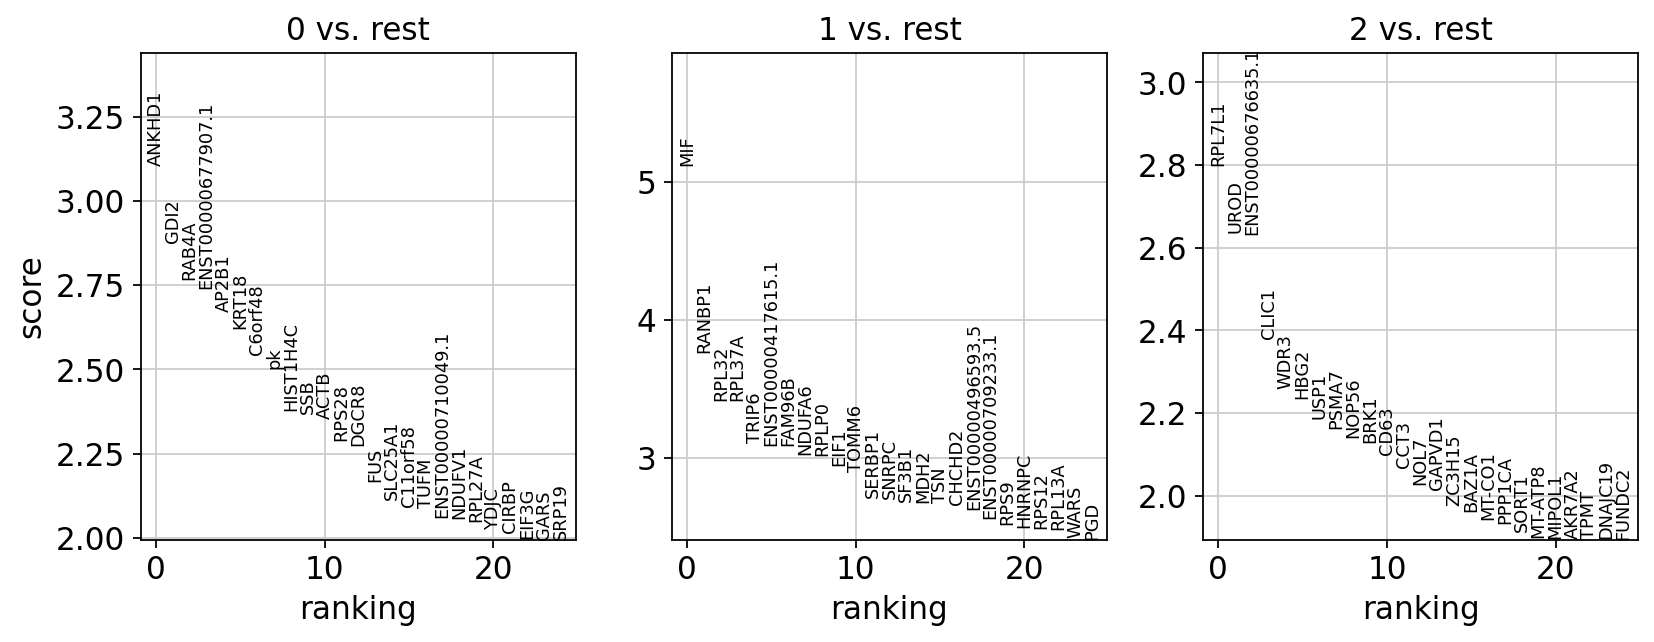

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/yichaocai/miniforge3/envs/py3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


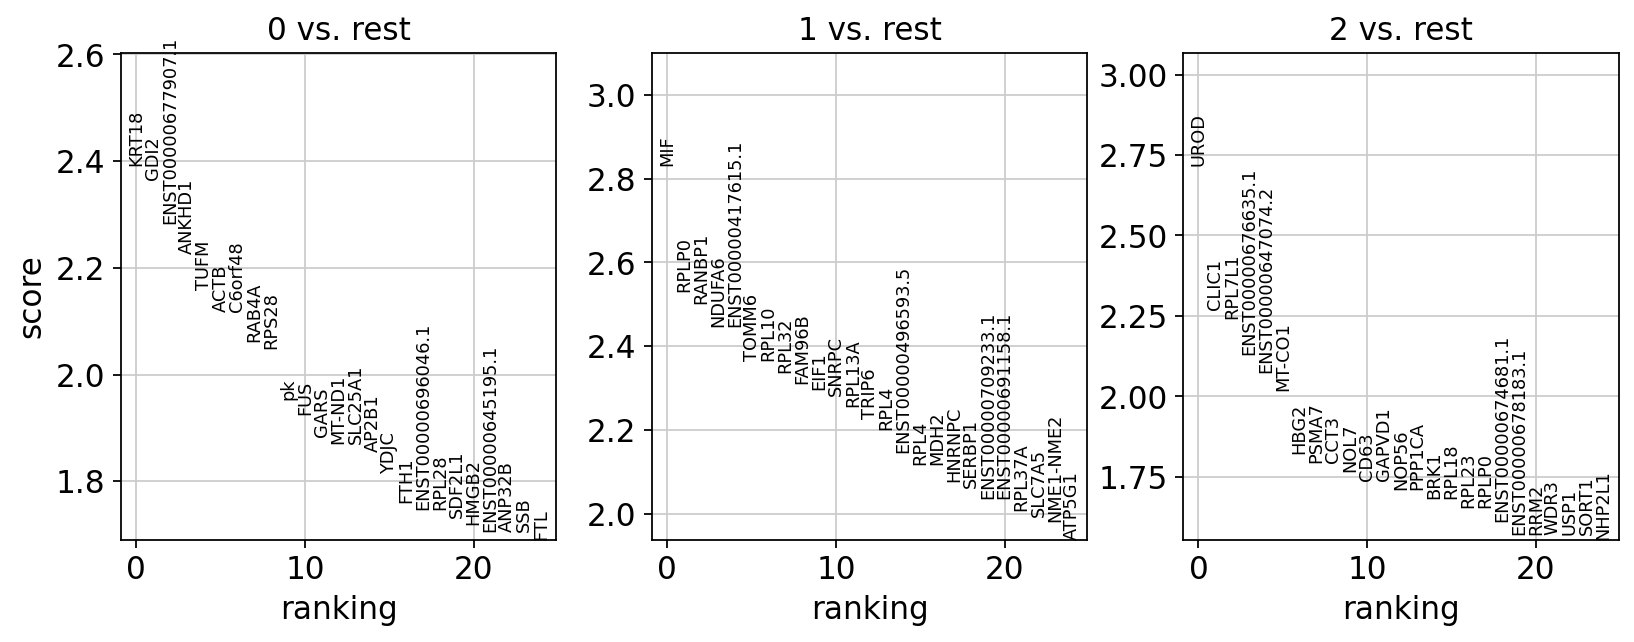

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:01)


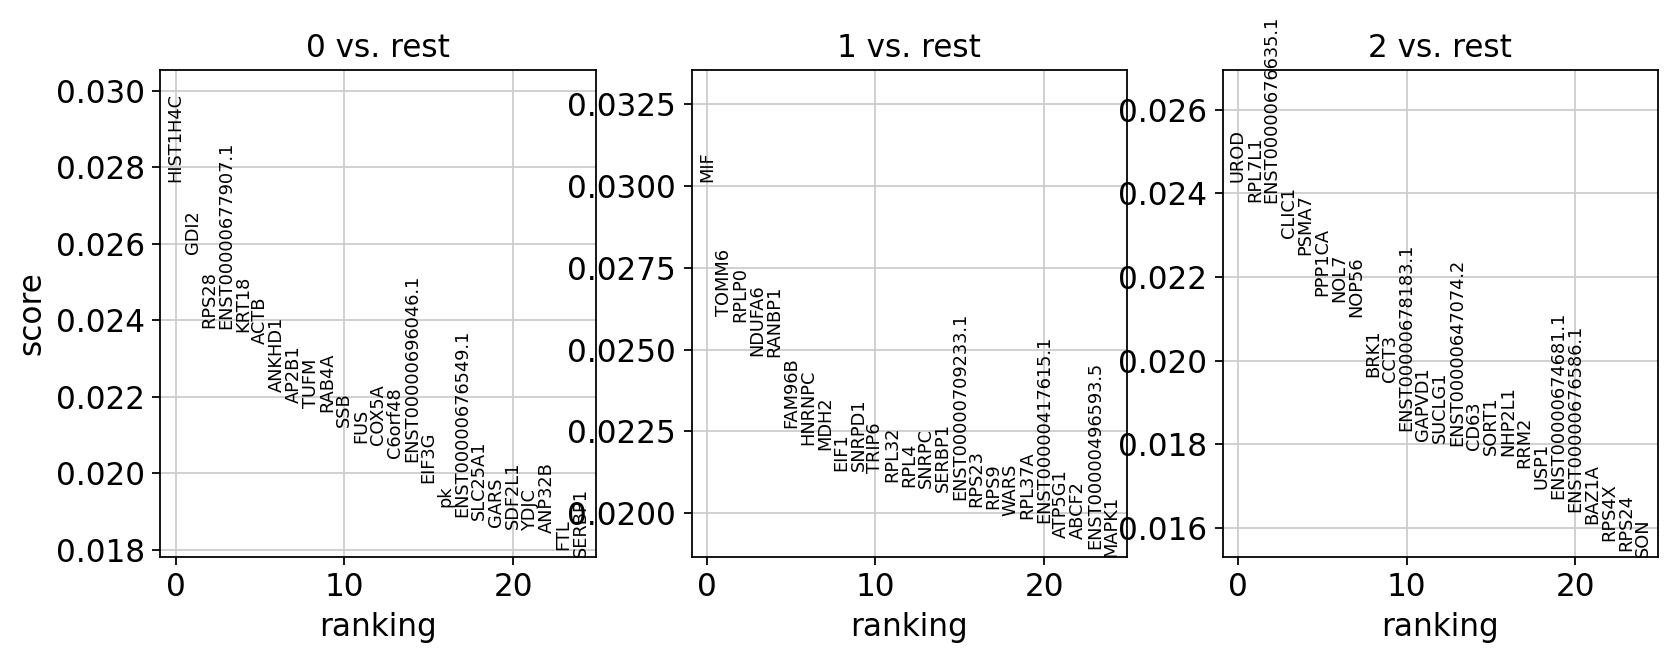

In [201]:
# Find marker genes in each cluster.
# Cluster 0: GDI2 - GDP Dissociation Inhibitor 2; 
# Cluster 1: MIF - Macrophage Migration Inhibitory Factor; high in K562
# Cluster 2: UROD - uroporphyrinogen decarboxylase; high in K562 (https://maayanlab.cloud/Harmonizome/gene_set/K562/BioGPS+Cell+Line+Gene+Expression+Profiles)

sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols='geneName')

sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols='geneName')

adata.write(f'./output_v1_2/Estimated_counts/{sample}_withAnalysis.h5ad')

sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols='geneName')



In [204]:
# Reload the data with wilcoxon test from previous step
adata = sc.read(f'./output_v1_2/Estimated_counts/{sample}_withAnalysis.h5ad')
# Top 5 gene in each cluster
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2
0,ENST00000548496.1,ENST00000215754.8,ENST00000472254.1
1,ENST00000380191.9,ENST00000392514.9,ENST00000423804.5
2,ENST00000677907.1,ENST00000331821.8,ENST00000493763.7
3,ENST00000246149.10,ENST00000498737.8,ENST00000676635.1
4,ENST00000569217.1,ENST00000417615.1,ENST00000647074.2


In [206]:
# Top 5 genes in each cluster and the p_value when tested in 1 v.s. the rest setting.
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p
0,ENST00000548496.1,0.016762,ENST00000215754.8,0.004629,ENST00000472254.1,0.006576
1,ENST00000380191.9,0.018060,ENST00000392514.9,0.011428,ENST00000423804.5,0.023247
2,ENST00000677907.1,0.022495,ENST00000331821.8,0.012355,ENST00000493763.7,0.025005
3,ENST00000246149.10,0.025952,ENST00000498737.8,0.014410,ENST00000676635.1,0.033233
4,ENST00000569217.1,0.030913,ENST00000417615.1,0.014410,ENST00000647074.2,0.038151


ranking genes
--> Few observations in a group for normal approximation (<=25). Lower test accuracy.
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


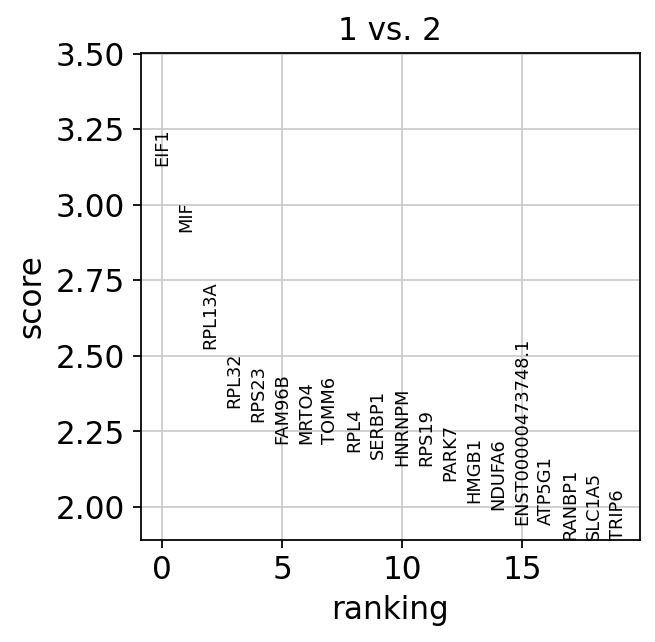

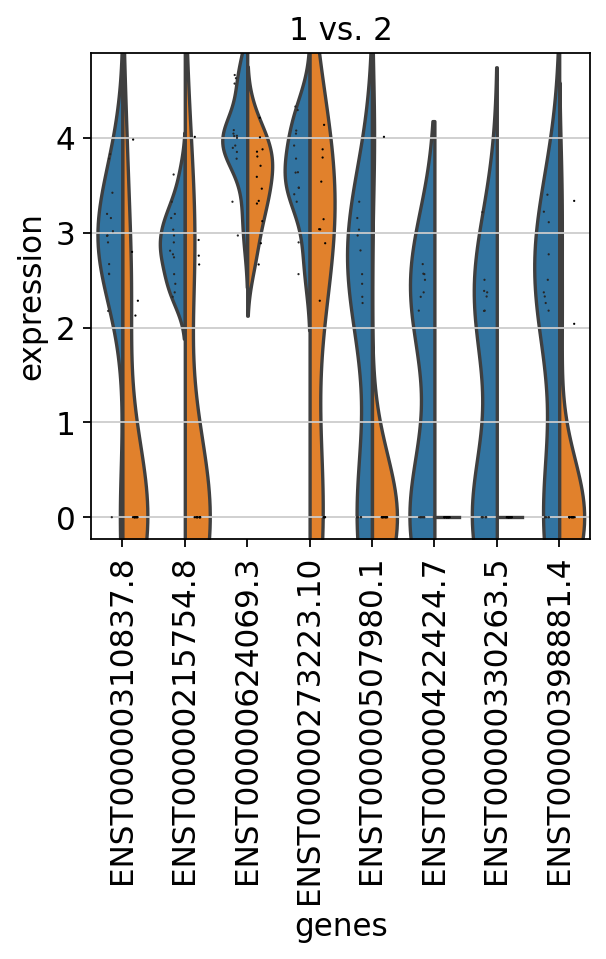

In [221]:
%%capture --no-display

# Do statistical testing with 2 clusters. Here we test cluster 1 v.s. cluster 2.
# EIF1 and MIF high in cluster 1 and low in cluster 2.
sc.tl.rank_genes_groups(adata, 'leiden', groups=['1'], reference='2', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['1'], n_genes=20, gene_symbols='geneName')
sc.pl.rank_genes_groups_violin(adata, groups=['1'], n_genes=8)    # gene_symbols='geneName' here not working. (see https://github.com/scverse/scanpy/issues/2258)

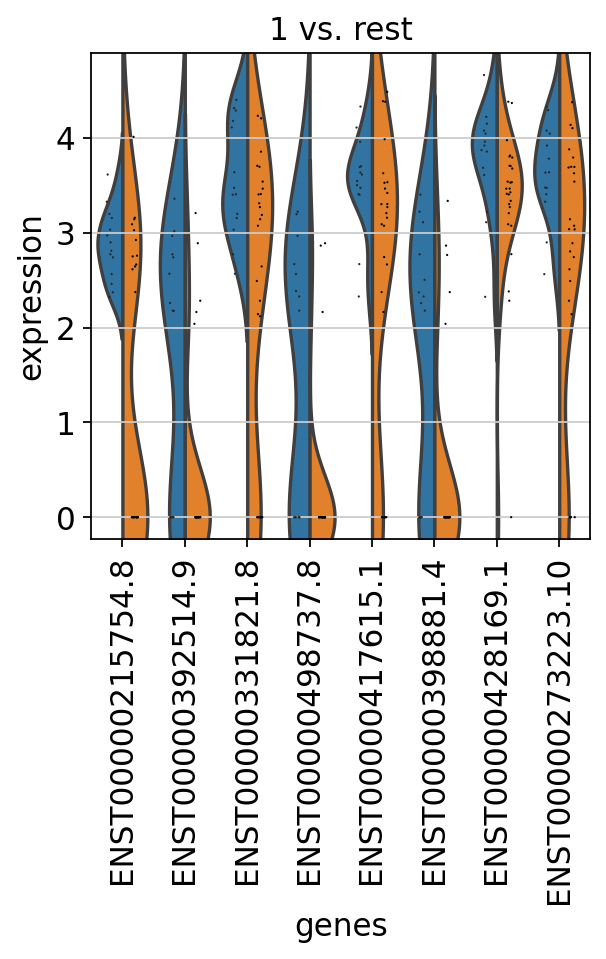

In [224]:
%%capture --no-display

# Comparing gene expression in multiple clusters
adata = sc.read(f'./output_v1_2/Estimated_counts/{sample}_withAnalysis.h5ad')
sc.pl.rank_genes_groups_violin(adata, groups=['1'], n_genes=8)

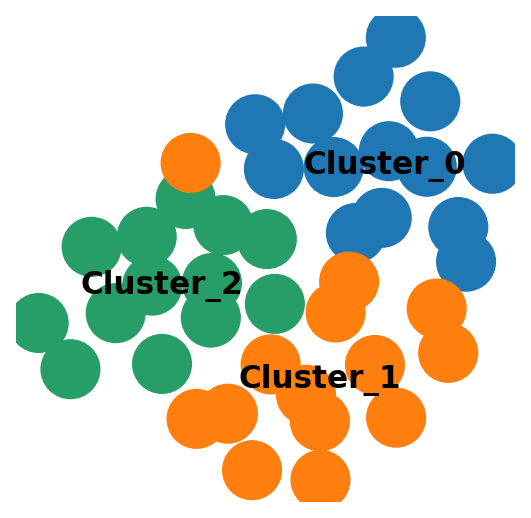

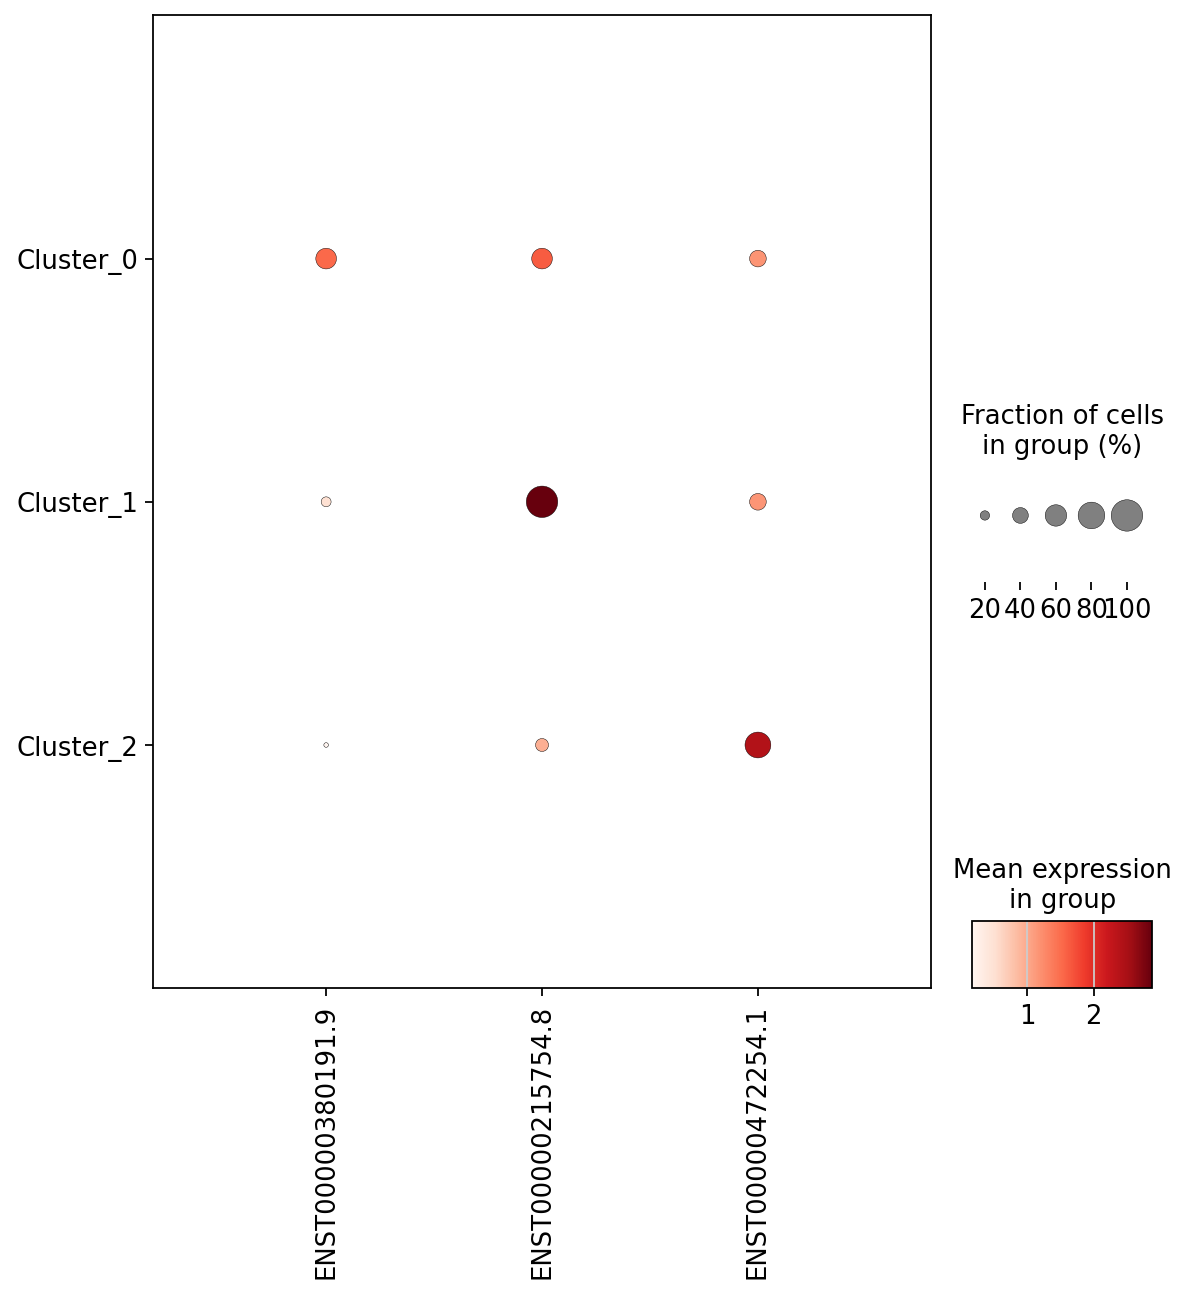

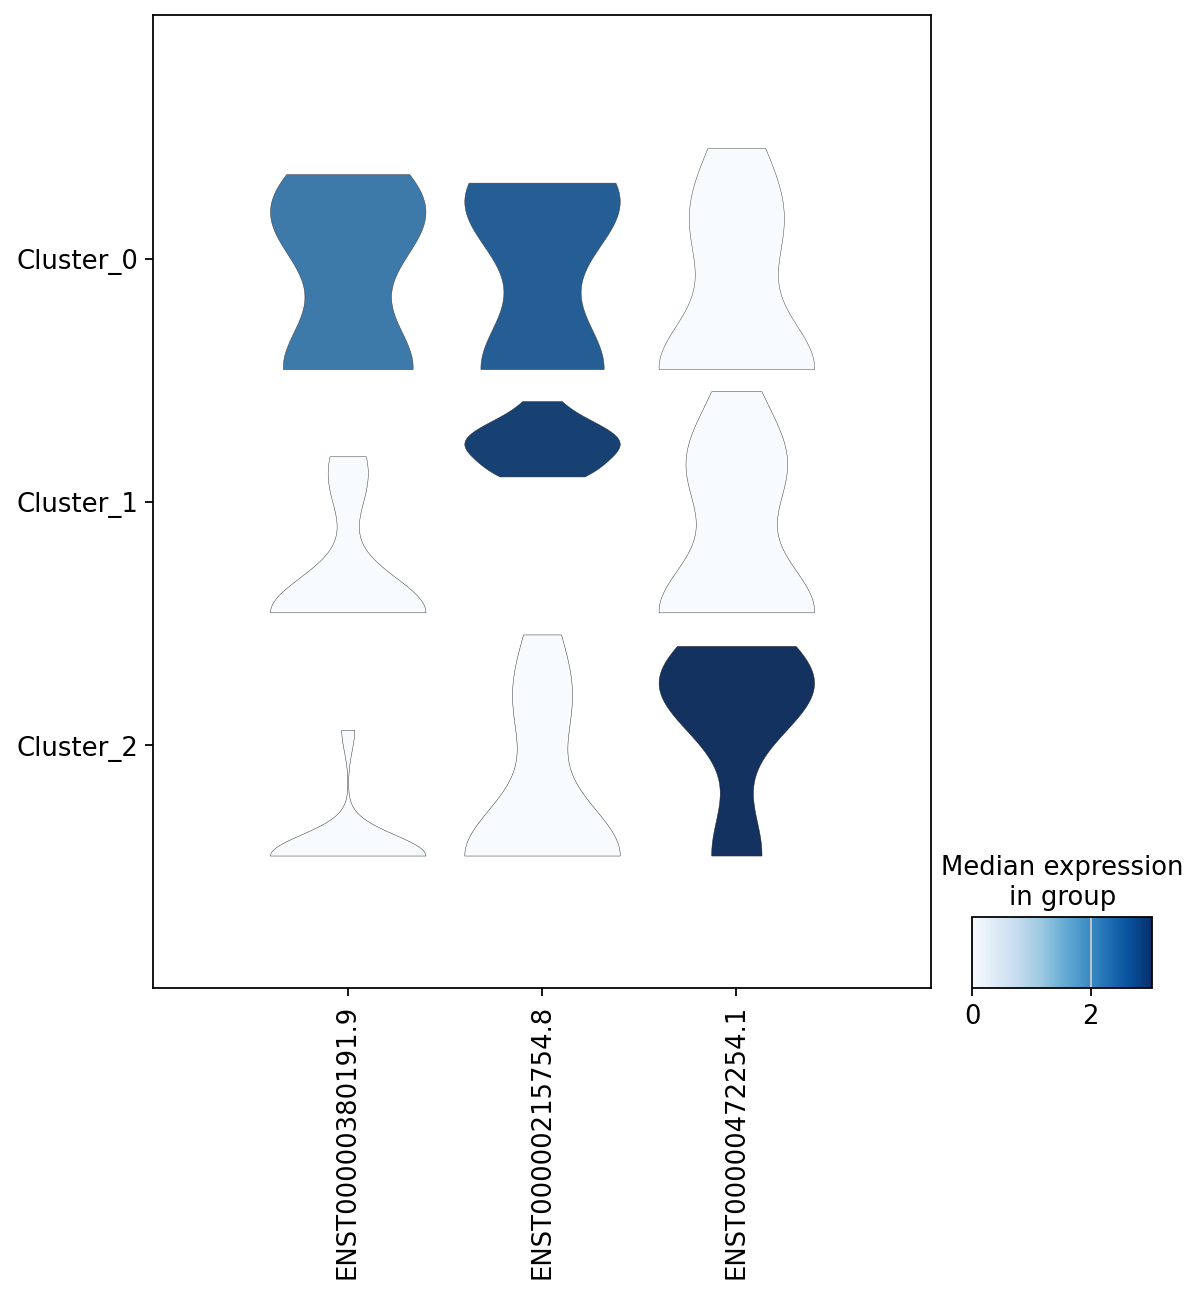

In [245]:
%%capture --no-display

# Since we don't know the subgroups of our single cells, using dummpy cluster names here.
new_cluster_names = ['Cluster_0', 'Cluster_1', 'Cluster_2']
adata.rename_categories('leiden', new_cluster_names)
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False)

# Heatmap on marker genes.
marker_genes = ['ENST00000380191.9', 'ENST00000215754.8', 'ENST00000472254.1'] # GDI2, MIF, UROD
sc.pl.dotplot(adata, marker_genes, groupby='leiden', figsize=(8,8))    # Again using gene_symbols cause a keyerror (https://github.com/scverse/scanpy/issues/1636)

# Violin plot on marker genes.
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90, figsize=(8,8))

In [246]:
adata

AnnData object with n_obs × n_vars = 41 × 1885
    obs: 'cell', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'louvain'
    var: 'transcriptId_stable', 'chrom', 'strand', 'txStart', 'txEnd', 'exonCount', 'geneName', 'geneId', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'louvain', 'louvain_colors', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [247]:
adata.write(f'./output_v1_2/Estimated_counts/{sample}_final.h5ad')